In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
rec_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(rec_date)

('2017-08-23',)


In [10]:
# Convert rec_date type to date.
recent_date =  dt.date(2017, 8, 23)
recent_date

datetime.date(2017, 8, 23)

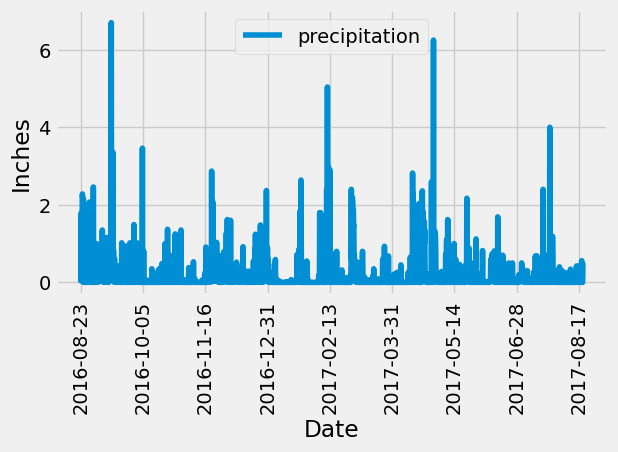

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = recent_date - dt.timedelta(days=365)
last_date
# Perform a query to retrieve the data and precipitation scores
query_retrieve = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= last_date ).\
    filter(measurement.date < recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurement_df = pd.DataFrame(query_retrieve)
measurement_df
# Sort the dataframe by date
Final_measurement_df = measurement_df.sort_values(by=['date'], ascending=True).dropna()
Final_measurement_df=Final_measurement_df.rename(columns={'prcp':'precipitation'})
Final_measurement_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
Final_measurement_df.plot(rot=90,xlabel='Date', ylabel = "Inches")
plt.tight_layout()
plt.savefig("output/Annual_Precipitation_Hawaii.png")

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
Final_measurement_df.describe()

,precipitation
count,2017.000000
mean,0.177367
std,0.461568
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_activity_count = session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).\
        order_by(func.count(measurement.date).desc()).all()
stations_activity_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
print(f'{stations_activity_count[0][0]} has the greatest number of observations.')

USC00519281 has the greatest number of observations.


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temp_summary = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
        filter(measurement.station == (stations_activity_count[0][0])).\
        group_by(measurement.station).all()
station_temp_summary

[(54.0, 85.0, 71.66378066378067)]

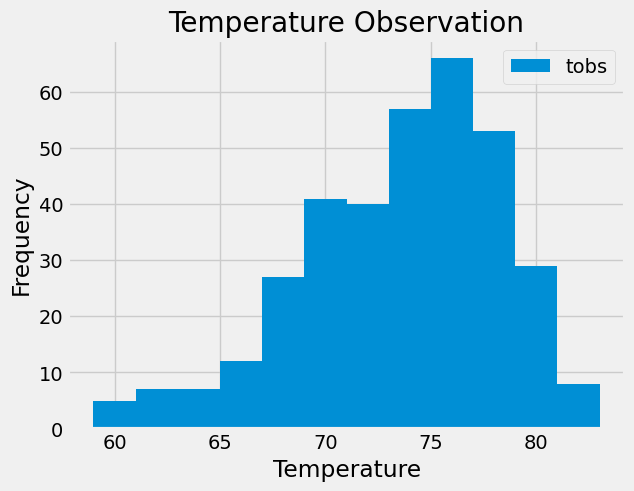

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observation = session.query(measurement.date, measurement.tobs).\
        filter(measurement.station == (stations_activity_count[0][0])).\
        filter(measurement.date >= last_date ).\
        filter(measurement.date <= recent_date).all()

temperature_df = pd.DataFrame(temperature_observation)
temperature_df

temperature_df.hist(bins=12, legend= True)
plt.title("Temperature Observation")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("output/Temperature Observation.png")

# Close Session

In [18]:
# Close Session
session.close()